We will now define the dataset class for our image dataset consisting of keypoint annotations inside images. When computing heatmaps(one for each keypoint present in an image), we will also make heatmaps for lines present in the annotation jsons for each image.

In [ ]:
from torch.utils.data.dataset import Dataset
from typing import List, Tuple, Callable, Optional
from pathlib import Path

import torch
import numpy as np
import cv2
import os
import json
import matplotlib.pyplot as plt

In [ ]:
from omegaconf import OmegaConf, DictConfig
cfg = OmegaConf.load('train_config.yaml')

In [ ]:
class HRNetDataset(Dataset):
    def __init__(self, dataset_folder: str, transform: Optional[Callable] = None, num_keypoints: int = 30, img_size: Tuple[int, int] = (960, 540), margin: float = 0.0):
        super().__init__()
        self.dataset_folder,self.num_keypoints,self.transform,self.img_size,self.margin = dataset_folder,num_keypoints,transform,img_size,margin
        self.img_paths = [p for p in Path(dataset_folder).glob('*.jpg') if p.with_suffix('.json').exists()][:1]        
    
    def __len__(self): return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if self.transform: sample = self.transform(sample)
        annot_path = img_path.with_suffix('.json')
        keypoints,mask,lines = self._annot2keypoints(annot_path)
        image,keypoints = self._resize_img_and_kpts(image, keypoints)
        sample = dict(image=image, keypoints=keypoints, img_idx=idx, mask=mask, img_name=img_path.name, lines=lines)
        return sample
    
    def _annot2keypoints(self, annot_path):
        with open(annot_path) as f: data = json.loads(f.read())
        kpts_dict,lines = {},[]
        for shape in data['shapes']:
            if shape['shape_type'] == 'point': kpts_dict[int(shape['label'])] = shape['points'][0]
            elif shape['shape_type'] == 'linestrip': lines.append(dict(label=shape['label'], points=shape['points']))
        keypoints = np.ones(self.num_keypoints * 3, dtype=np.float32) * -1
        mask = np.ones(self.num_keypoints, dtype=int)
        for i in range(self.num_keypoints):
            if i in kpts_dict:
                keypoints[i*3:i*3+2] = kpts_dict[i]
                keypoints[i*3+2] = 1
                mask[i] = 0
            else: keypoints[i*3+2] = 0
        return keypoints,mask,lines
    
    def _resize_img_and_kpts(self, image, keypoints):
        h,w = image.shape[:2]
        tw,th = self.img_size
        scale_h,scale_w = th/h,tw/w
        resized_img = cv2.resize(image, (tw,th))
        for i in range(self.num_keypoints):
            if keypoints[i*3+2] > 0: keypoints[i*3],keypoints[i*3+1] = keypoints[i*3]*scale_w,keypoints[i*3+1]*scale_h
        return resized_img,keypoints


In [ ]:
def gaussian(x: torch.Tensor, mu: torch.Tensor, sigma: float) -> torch.Tensor:
    """1D Gaussian distribution. The distribution amplitude is 1.0.

    Args:
        x (torch.Tensor): 1D tensor of X values, (X,).
        mu (torch.Tensor): Mean values for gaussian (B, N).
        sigma (float): Standard deviation in scale of X axis.

    Returns:
        torch.Tensor: Resulted 1d gaussians: (B, N, X).
    """
    return torch.exp(-(torch.div(x - mu.unsqueeze(-1), sigma) ** 2) / 2.0)

def create_heatmaps(keypoints: torch.Tensor, sigma: float, pred_size: Tuple[int, int] = (540, 960)) -> torch.Tensor:
    h,w = pred_size
    device = keypoints.device
    x,y,vis = keypoints[:,:,0],keypoints[:,:,1],keypoints[:,:,2]
    x_range,y_range = torch.arange(0, w, device=device, dtype=torch.float32),torch.arange(0, h, device=device, dtype=torch.float32)
    gauss_x,gauss_y = gaussian(x_range, x, sigma),gaussian(y_range, y, sigma)
    heatmaps = torch.einsum("BNW, BNH -> BNHW", gauss_x, gauss_y)
    heatmaps = torch.where((vis > 0).unsqueeze(-1).unsqueeze(-1), heatmaps, torch.tensor(0.0, device=device))
    return heatmaps

Why do you need to unsqueeze vis two times? walk me throuugh the shapes step by step

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Let's trace through the shapes:

- `keypoints` shape: `(B, N, 3)` where B is batch size, N is number of keypoints
- `vis = keypoints[:,:,2]` shape: `(B, N)` - just the visibility values
- `gauss_x` shape: `(B, N, W)` - Gaussian for each keypoint along width
- `gauss_y` shape: `(B, N, H)` - Gaussian for each keypoint along height
- `heatmaps = torch.einsum("BNW, BNH -> BNHW", gauss_x, gauss_y)` shape: `(B, N, H, W)`

Now for masking:
- `vis` is `(B, N)` 
- `vis > 0` is still `(B, N)` - boolean mask
- `.unsqueeze(-1)` gives `(B, N, 1)` - adds dimension for H
- `.unsqueeze(-1)` again gives `(B, N, 1, 1)` - adds dimension for W

This broadcasts correctly with `heatmaps` which is `(B, N, H, W)`:
- The `(B, N, 1, 1)` mask broadcasts to `(B, N, H, W)` by repeating along H and W dimensions
- So each keypoint's entire H×W heatmap is either kept (if vis=1) or zeroed (if vis=0)

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset, default_collate
from typing import List, Optional, Callable

collate_objs = ['keypoints', 'image', 'img_idx', 'mask']

def custom_collate(batch):
    default_collated = default_collate([{k: v for k, v in sample.items()
                                         if k in collate_objs}
                                        for sample in batch])
    custom_collated = {'img_name': [sample['img_name'] for sample in batch]}

    return {**default_collated, **custom_collated}

def train_transform(brightness: Tuple[float, float] = (0.8, 1.2),
                    color: Tuple[float, float] = (0.8, 1.2),
                    contrast: Tuple[float, float] = (0.8, 1.2),
                    gauss_noise_sigma: float = 30.0,
                    prob: float = 0.5):
    transforms = ComposeTransform([
        UseWithProb(ColorAugment(brightness=brightness,
                                 color=color,
                                 contrast=contrast), prob),
        UseWithProb(GaussNoise(gauss_noise_sigma), prob),
        # UseWithProb(Flip(), 0.5),
        ToTensor()
    ])
    return transforms
    
def get_loader(dataset_paths: List[str], data_params: DictConfig,

               transform: Optional[Callable] = None, shuffle: bool = True)\
        -> DataLoader:
    datasets = []
    for dataset_path in dataset_paths:
        datasets.append(HRNetDataset(dataset_path, transform=transform,
                                     num_keypoints=data_params.num_keypoints,
                                     margin=data_params.margin))
    dataset = ConcatDataset(datasets)
    factor = 1 if shuffle else 2
    loader = DataLoader(
        dataset, batch_size=data_params.batch_size * factor,
        num_workers=data_params.num_workers,
        pin_memory=data_params.pin_memory,
        shuffle=shuffle,
        collate_fn=custom_collate)
    return loader

In [ ]:
def plot_heatmap_on_img(img_tensor, heatmap_tensor):
    img = img_tensor.detach().cpu().numpy()
    heatmap = heatmap_tensor.detach().cpu().numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img.astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)
    plt.imshow(overlay)
    plt.show()

torch.Size([540, 960, 3]) tensor([[[ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [459.8754, 180.5572,   1.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [387.1507, 310.7205,   1.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [499.9047, 198.5924,   1.0000],
         [893.8522, 371.1214,   1.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [362.9445, 193.7778,   1.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,   0.0000],
         [ -1.0000,  -1.0000,  

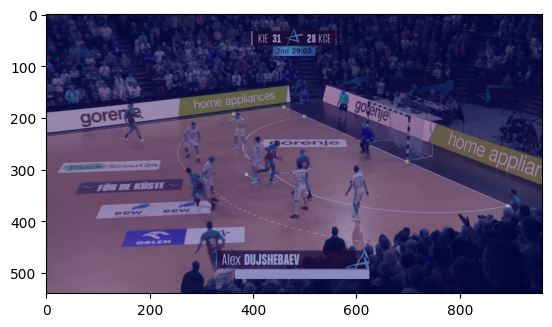

heatmap shape (540, 960)


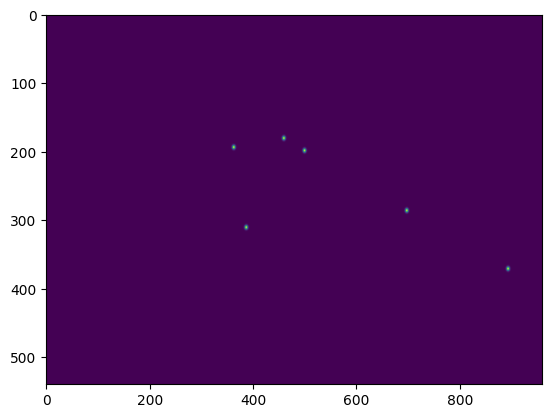

In [ ]:
train_loader = get_loader(cfg.data.train, cfg.data_params, None, True)
dl = iter(train_loader)

for batch in dl:
    for idx in range(cfg.data_params.batch_size):
        img, keypoints, mask = batch['image'][idx], batch['keypoints'][idx].reshape(-1, cfg.data_params.num_keypoints, 3), batch['mask'][idx]
        print(img.shape, keypoints)
        heatmaps = create_heatmaps(keypoints, 2)
        heatmaps = torch.cat(
                [heatmaps, (1.0 - torch.max(heatmaps, dim=1, keepdim=True)[0])], 1)
        maps = torch.sum(heatmaps[0][:-1], 0)
        plot_heatmap_on_img(img, maps)
        plot_heatmap(maps)
